# Interface tutorial

First, we load the stored `ExperimentData` object from the directory "mcmc/experiment_data".



In [1]:
import numpy as np
from simulate_data import load_experiment_data

data = load_experiment_data("experiment_data")

We can access the noisy measurement $y$ and standard deviations $\sigma_y$:

<>:10: DeprecationWarning: invalid escape sequence \l
<>:13: DeprecationWarning: invalid escape sequence \s


Distribution functions should have shape (12, 53)
Distribution functions should have shape (12, 53)


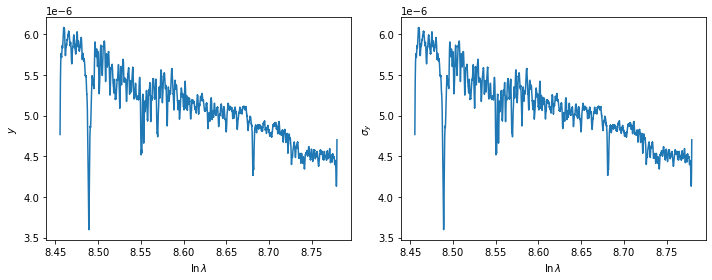

In [2]:
y = data.y
y_sd = data.y_sd

from matplotlib import pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(data.ssps.w, y)
ax2.plot(data.ssps.w, y)
ax1.set_xlabel('$\ln \lambda$')
ax1.set_ylabel('$y$')
ax2.set_xlabel('$\ln \lambda$')
ax2.set_ylabel("$\sigma_{y}$")
fig.set_size_inches(10, 4)
plt.tight_layout()
plt.show()


The ground truth $f$ for the distribution function is given by
`experiment_data.f`.

In [ ]:
from uq4pk_fit.visualization import plot_distribution_function

f = data.f_true
f_im = f.reshape((12, 53))
plot_distribution_function(image=f_im, ssps=data.ssps)


Next, we set up our statistical model. It is of the general form

$\begin{align}
\mathbf{y} &= \mathcal G(\mathbf{f}, \boldsymbol{\theta}_v) + \boldsymbol{\eta}, \\
\mathbf{\eta} & \sim \mathcal N(\mathbf{0}, \boldsymbol{\sigma}_{\mathbf{y}}^2), \\
\mathbf f &\sim \mathcal N_{\geq  \mathbf{0}}(\bar{\mathbf f}, \boldsymbol{\Sigma}_1),
\quad \boldsymbol\Sigma_1 = \frac{1}{\beta_1}  (\mathbf P_1 \mathbf P_1^\top)^{-1},\\
 \boldsymbol{\theta}_v &\sim \mathcal N(\bar{\boldsymbol \theta}_v, \boldsymbol\Sigma_2), \quad
\boldsymbol\Sigma_2 = \frac{1}{\beta_2} (\mathbf P_2 \mathbf P_2^\top)^{-1}.
\end{align}$

Here, $\mathcal G$ is our forward operator and $\mathcal N_{\geq \mathbf 0}$ denotes the truncated normal distribution.

The forward operator is implemented in the class [ForwardOperator](../uq4pk_fit/inference/forward_operator.py).
It is accessible through the `get_forward_operator`-method:

In [5]:
forward_operator = data.get_forward_operator()


Distribution functions should have shape (12, 53)
Distribution functions should have shape (12, 53)


We initialize the model as follows:

In [7]:
from uq4pk_fit.inference import StatModel

model = StatModel(y=y, y_sd=y_sd, forward_operator=forward_operator)

The initialization sets all model parameters like $\bar{\mathbf f}$, $\beta_1$, ...,
to default values. The default values are accessible through the object `model`.

Let me list the default choices:

- $\beta_1 = \mathrm{snr} \cdot 1000$.
This is just a rule-of-thumb that I found to work reasonably well for the experiments.
- $\bar{\mathbf f} = \mathbf 0$.
- The covariance matrix $\boldsymbol\Sigma_1$ for the distribution function is an Ornstein-Uhlenbeck covariance.
- I performed all the experiments with $\theta_v$ fixed at its true value, so that our model reduces
to a linear one.

All the relevant parameters can be accessed as follows:

In [8]:
beta1 = model.beta1     # The regularization parameter for f.
P1 = model.P1.mat       # The matrix corresponding to the regularization operator for f.
f_bar = model.f_bar     # The prior mean for f.
# In particular, the covariance matrix for f is given by
Sigma_1 = (1/beta1) * P1 @ P1.T

Furthermore, I performed the experiments under the normalization-assumption. That is, I
assumed that $\mathbf f$ is normalized:

$ \sum_i f_i = 1.$

## Dealing with equality constraints

If the MCMC-method has no direct way of addressing the equality-constraint, one can use
a linear transformation to reparametrize the model into an equivalent model that
automatically incorporates the equality constraint. The trick is to apply a QR decomposition
to the constraint equation

$
\mathbf{C} \mathbf{f} = 1, \quad \text{where } \mathbf C = \begin{bmatrix} 1 & 1 & \ldots & 1 \end{bmatrix}.
$

That is, let

$
\mathbf{C}^\top = \mathbf{Q} \mathbf{R} =
\begin{bmatrix} \mathbf{Q}_1 & \mathbf{Q}_2 \end{bmatrix}
\begin{bmatrix} r_1 \\ \mathbf{0}_{n - 1} \end{bmatrix}
$


where $n = \mathrm{dim}(\mathbf f)$. If we define

$
\begin{bmatrix}
q_1 \\ q_2
\end{bmatrix} := \mathbf{Q}^\top \mathbf f =
\begin{bmatrix} \mathbf Q_1^\top \mathbf f \\ \mathbf Q_2^\top \mathbf f \end{bmatrix}
$

and insert this into the constraint equation, we obtain

$
\mathbf C \mathbf f = 1, \quad \Leftrightarrow \quad \mathbf R^\top \mathbf Q^\top \mathbf f = 1
\quad \Leftrightarrow \quad q_1 r_1 = 1.
$

That is, we satisfy the constraint by setting $q_1 = \frac{1}{r_1}$. The parameter $\mathbf q_2 \in \mathbb{R}^{n-1}$
is now unconstrained, and we can translate our statistical model for $\mathbf f$ to an equivalent statistical
model for $\mathbf q_2$ using the relation $\mathbf q_2 = \mathbf Q_2^\top \mathbf f$
(treating the parameter $\boldsymbol{\theta}_v$ as given):

$\begin{align}
\mathbf{y} &= \mathcal G(\mathbf{f}, \boldsymbol{\theta}_v) + \boldsymbol{\eta}, \\
\mathbf{\eta} & \sim \mathcal N(\mathbf{0}, \boldsymbol{\sigma}_{\mathbf{y}}^2), \\
\mathbf f & = \mathbf f_1 + \mathbf Q_2 \mathbf q_2, \quad \mathbf f_1 = \mathbf Q_1 q_1, \\
\mathbf q_2 & \sim \mathcal{N}_{\mathbf Q_2 \mathbf q_2 \geq - \mathbf f_1}
(\bar{\mathbf q}_2, \mathbf \Sigma_{\mathbf q_2}),
\quad \bar{\mathbf q}_2 = \mathbf Q_2^\top \bar{\mathbf f},
\qquad \mathbf \Sigma_{\mathbf q_2} = \mathbf Q_2^\top \mathbf \Sigma_1 \mathbf Q_2.
\end{align}$


Here, $\mathcal N_{\mathbf Q_2 \mathbf q_2 \geq - \mathbf f_1}$ denotes the multivariate Gaussian truncated to
the set $\{\mathbf q_2 | \mathbf Q_2 \mathbf q_2 \geq - \mathbf f_1 \}$.
